In [218]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import result_handler as rh
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score



In [219]:
RELOAD_DATA = False
RESULTS_DIR = Path('../translations')
RESULTS_NAME = 'cross_tests_results.csv'

if RELOAD_DATA:
    rh.concatenate_csv_files(RESULTS_DIR, 'predictions.csv', RESULTS_NAME)

df = pd.read_csv(RESULTS_NAME)

In [220]:
grouped = df.groupby(['model_name', 'train_dataset', 'test_dataset'])
normalize = 'true' #Normalize the confusion matrix by row (true) or by column (pred)
def plot_consufion_matrices(grouped: pd.DataFrame, normalize: str = 'true'):
    if normalize == 'true':
        norm = 'by the true labels'
    else:
        norm = 'by the predicted labels'

    for (model, train_ds, test_ds), group in grouped:
        # Compute confusion matrix
        labels = sorted(set(group['label'].unique().tolist() + group['prediction'].unique().tolist()))
        cm = confusion_matrix(group['label'], group['prediction'], labels=labels, normalize=normalize)
        
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Model: {model}\nTrain Dataset: {train_ds}\nTest Dataset: {test_ds}\n Normalized by {norm}', loc = 'left')
        plt.show()


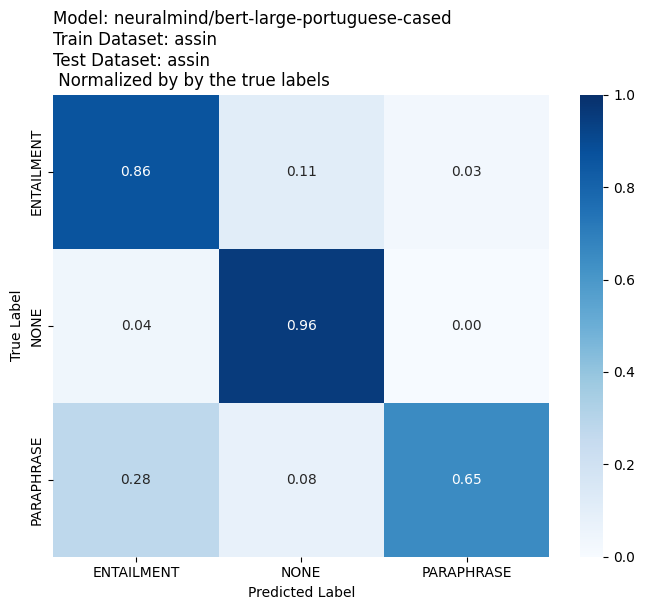

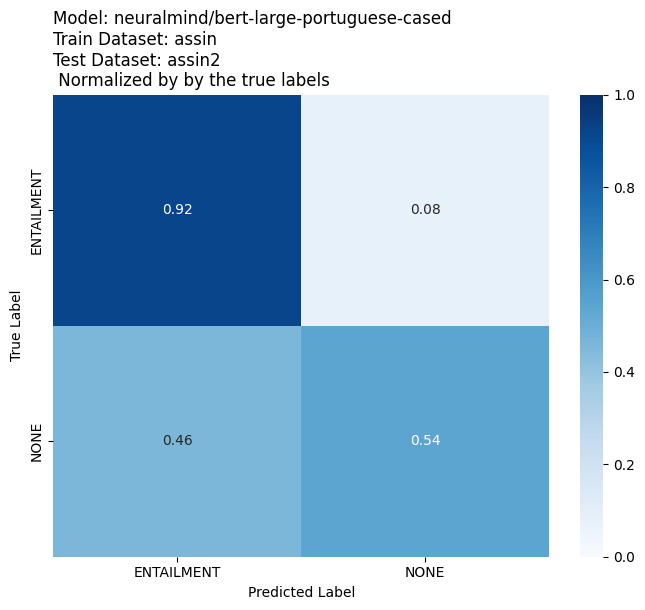

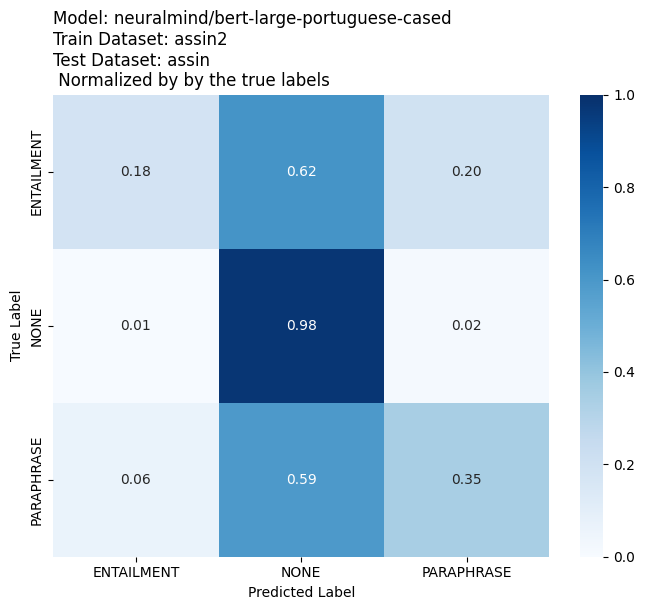

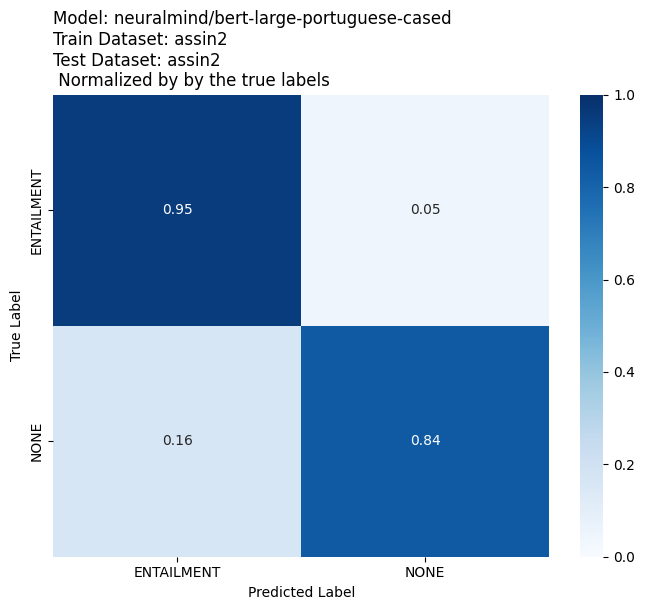

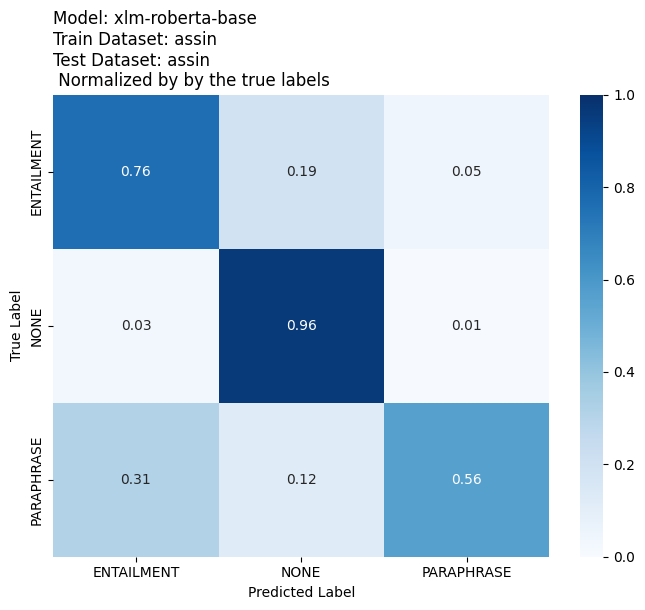

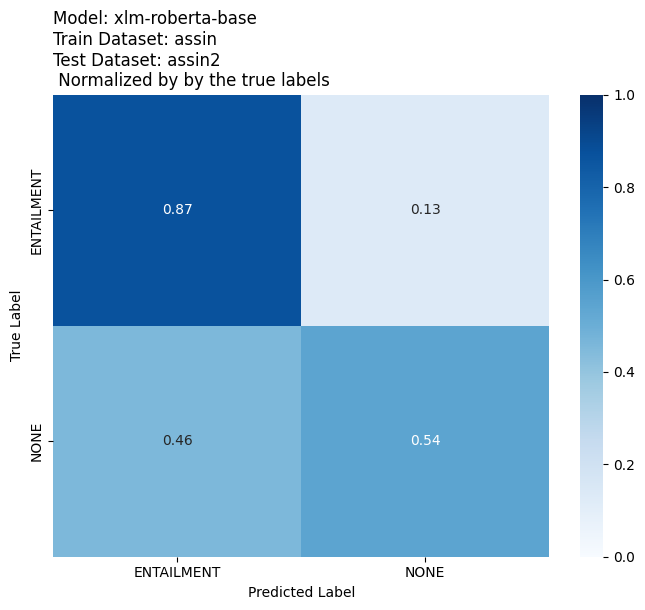

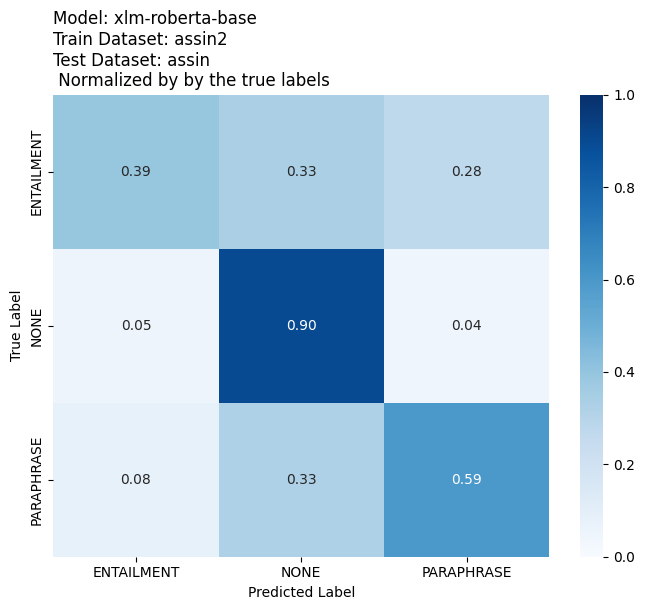

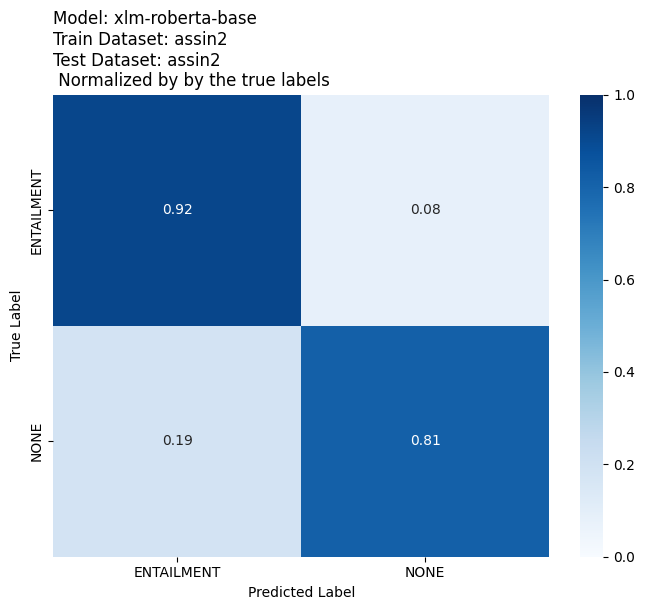

In [221]:
plot_consufion_matrices(grouped, normalize='true')  

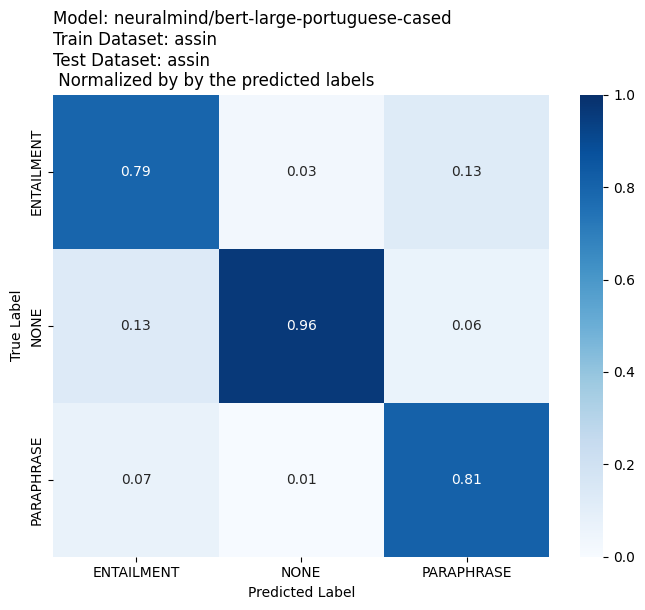

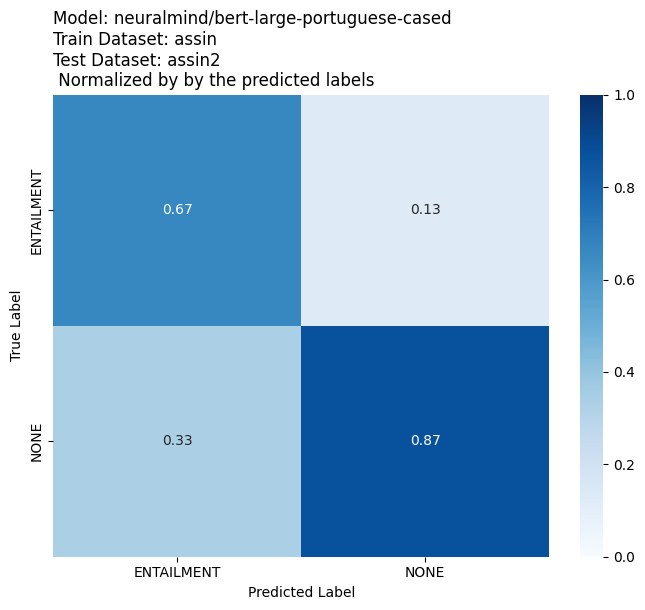

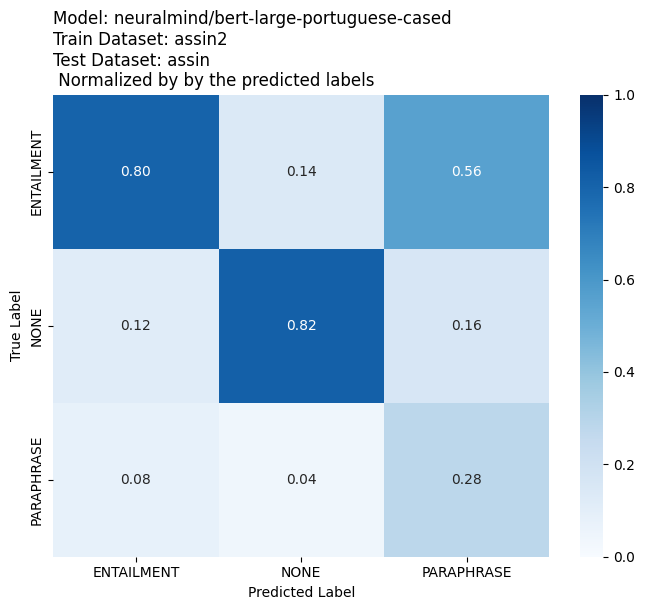

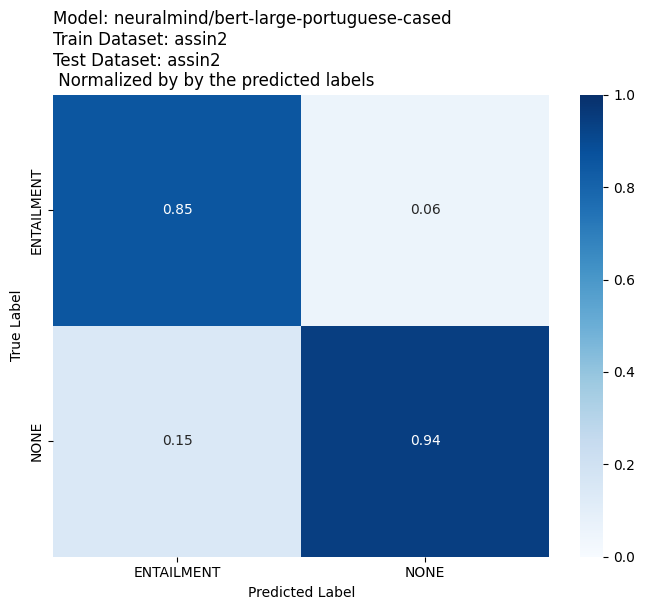

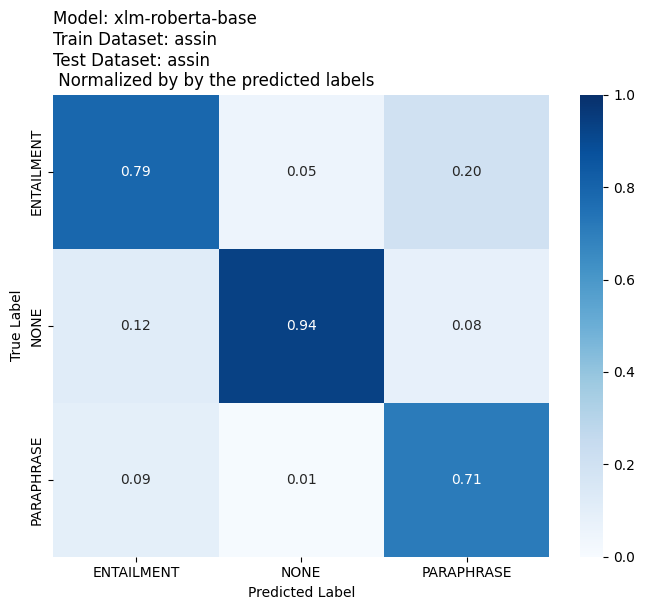

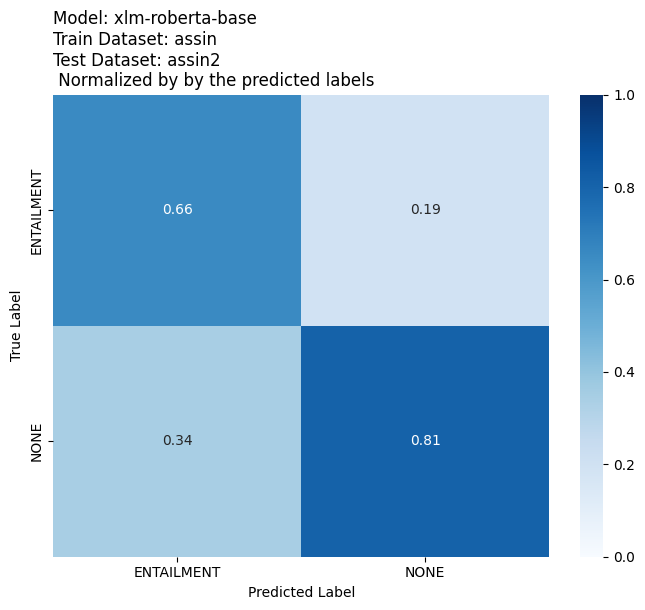

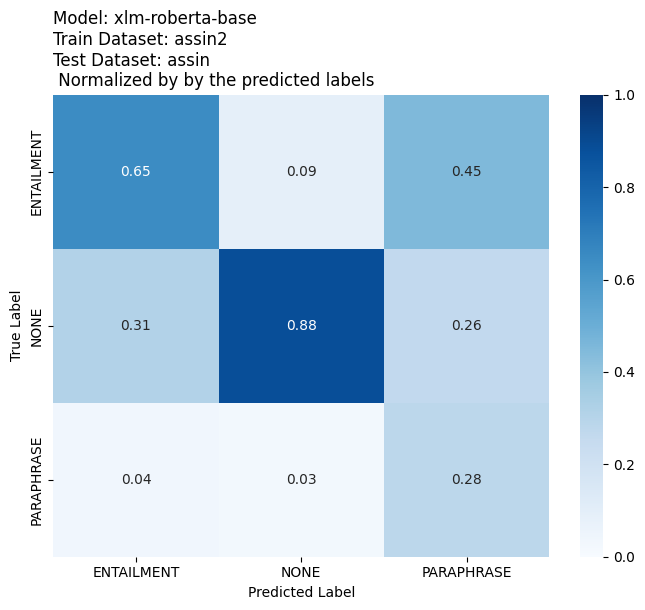

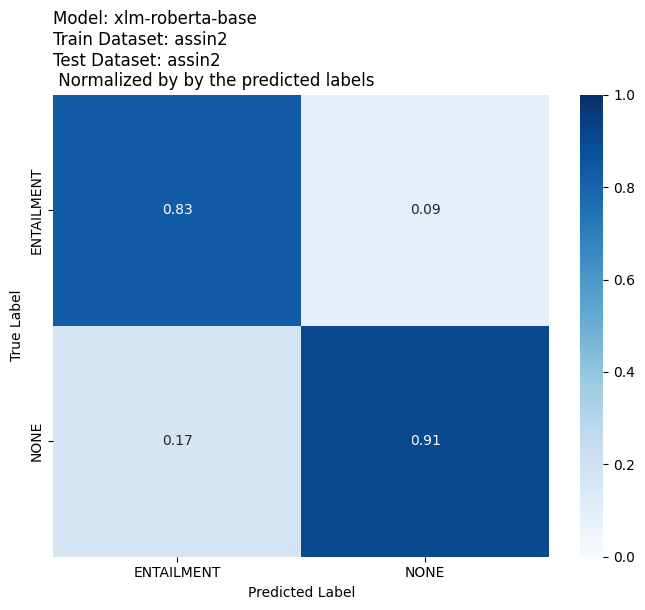

In [222]:
plot_consufion_matrices(grouped, normalize='pred')

In [223]:
metrics_data = []

for (model, train_ds, test_ds), group in grouped:
    accuracy = accuracy_score(group['label'], group['prediction'])
    precision = precision_score(group['label'], group['prediction'], average='macro')
    f1 = f1_score(group['label'], group['prediction'], average='macro')
    recall = recall_score(group['label'], group['prediction'], average='macro')
    metrics_data.append((model, train_ds, test_ds, accuracy, precision, recall, f1))

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_data, columns=['model_name', 'train_dataset', 'test_dataset', 'accuracy', 'precision','recall', 'f1'])

In [224]:
metrics_df.to_csv('results.csv', index=False)

In [225]:
def plot_metrics_results(metrics_df: pd.DataFrame, model_name: str, metric: str):
    plot = metrics_df[metrics_df['model_name'] == model_name].pivot(index = "train_dataset",
                                                                    columns = "test_dataset",
                                                                    values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=".2f", vmin=0.5, vmax=1)
    plt.title(f"{metric[0].upper() + metric[1:]} for {model_name}")
    plt.show()

In [229]:
def plot_models_benchmark_results(metrics_df: pd.DataFrame, metric: str):
    plot = metrics_df.pivot(index = "test_dataset",columns = "model",values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=".2f", vmin=0.5, vmax=1)
    plt.title(f"Model's {metric} comparison")
    plt.xticks(rotation=90)
    plt.show()

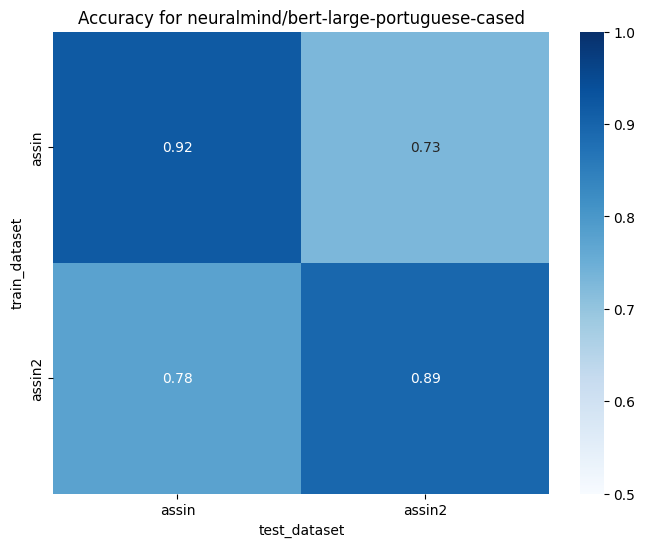

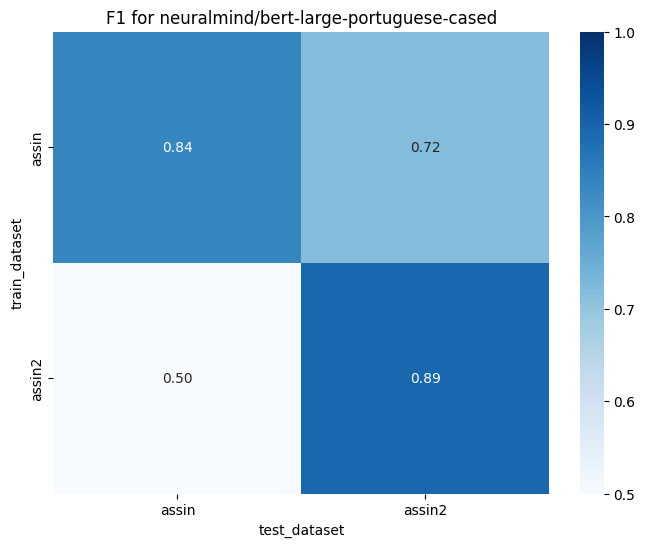

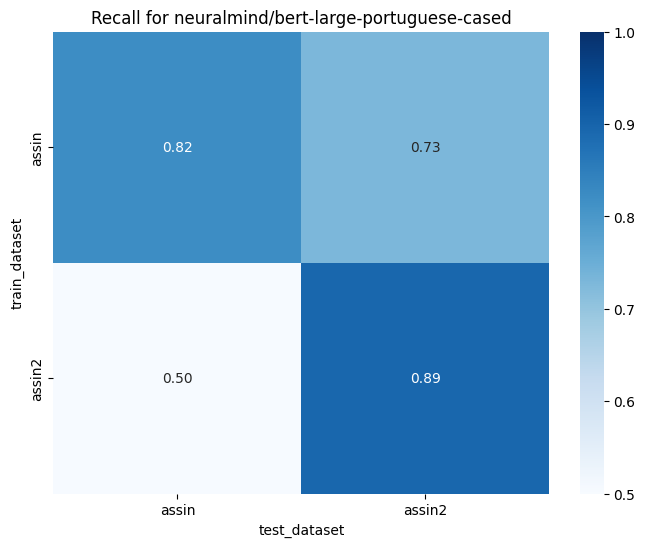

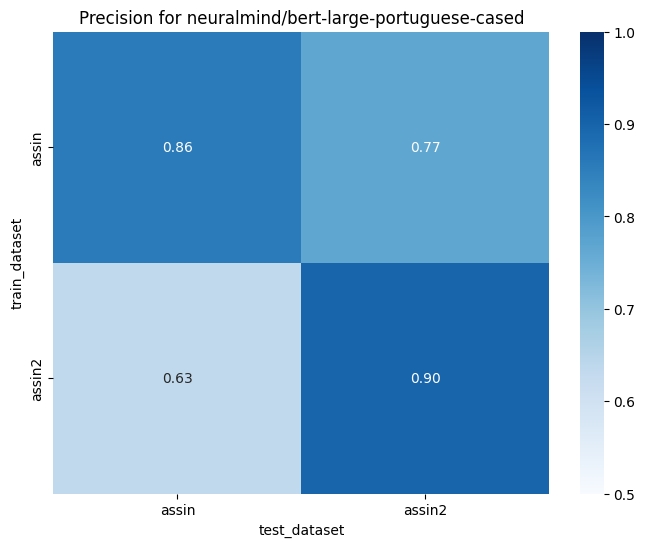

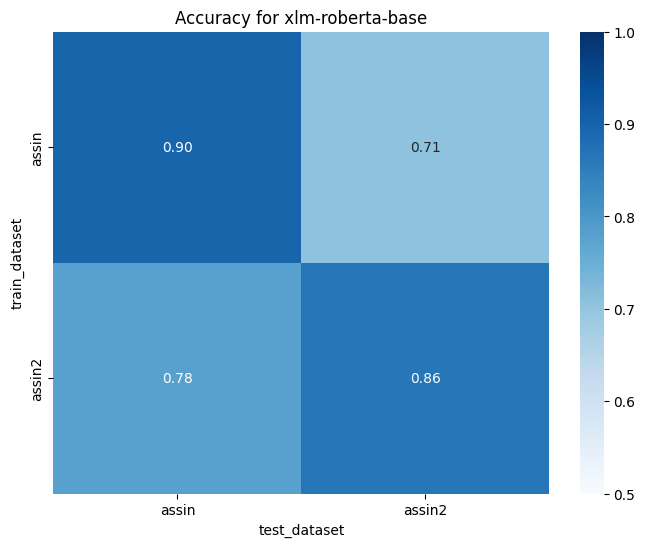

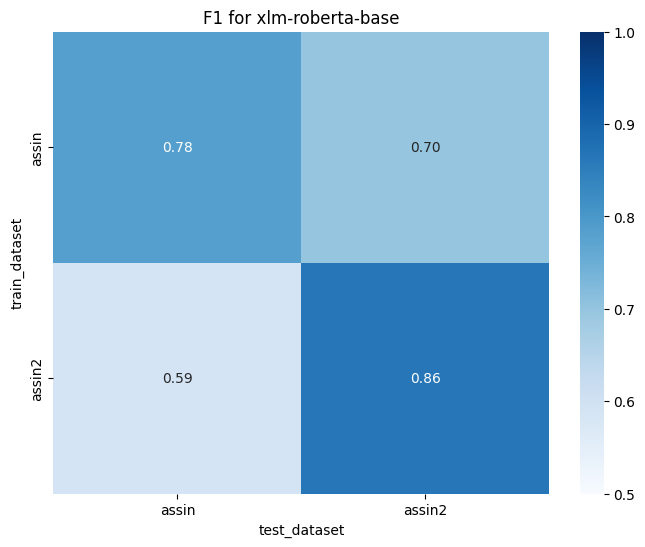

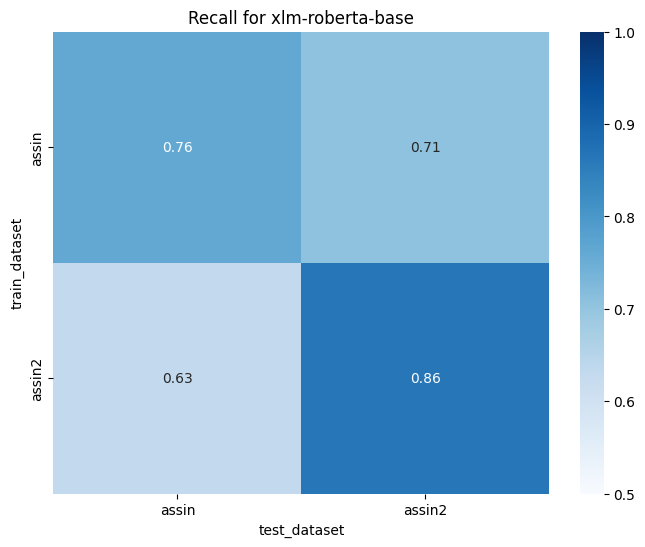

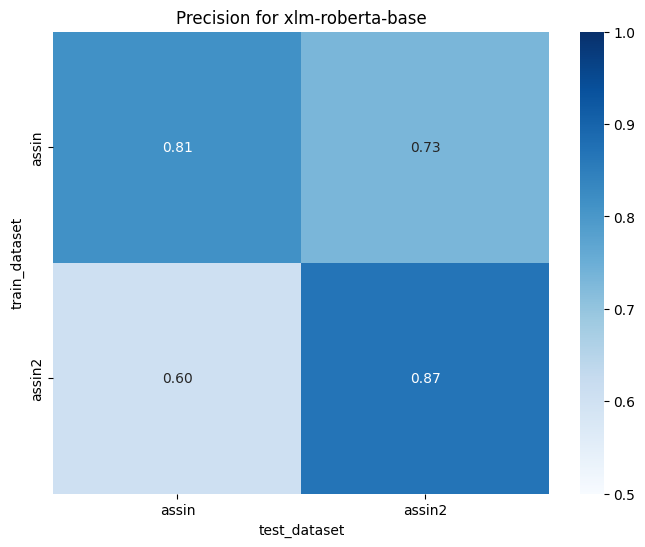

In [230]:
model_names = metrics_df['model_name'].unique()
for model_name in model_names:
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        plot_metrics_results(metrics_df, model_name, metric)

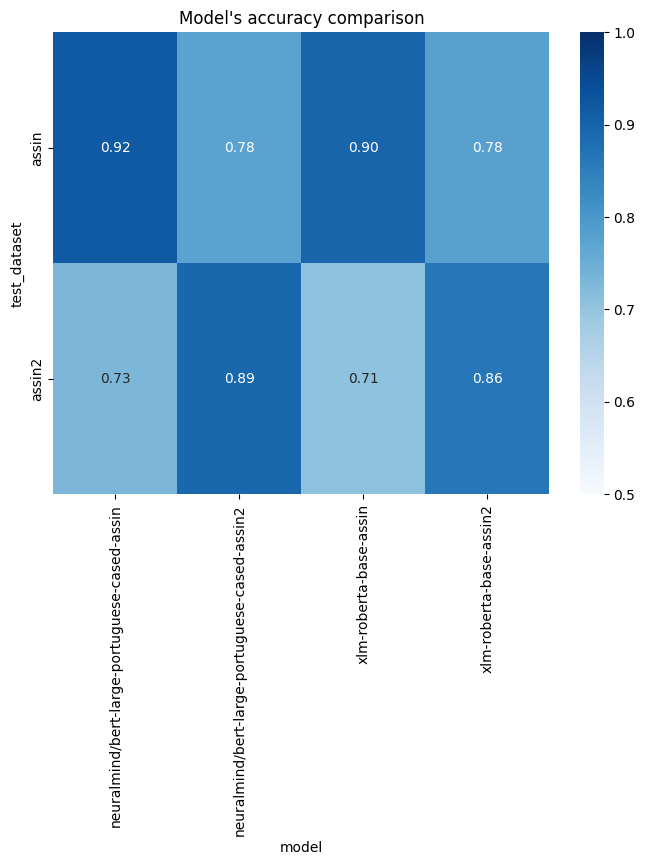

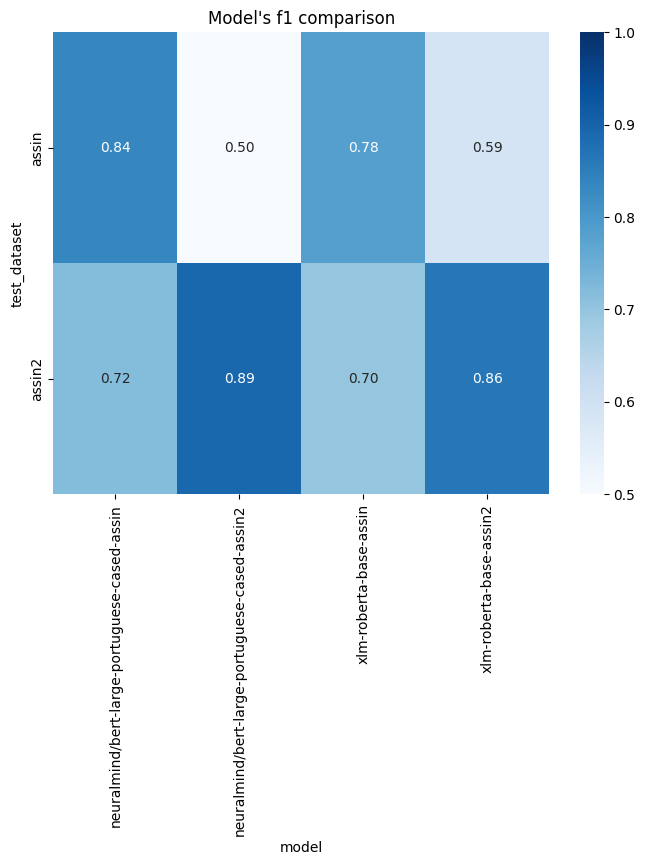

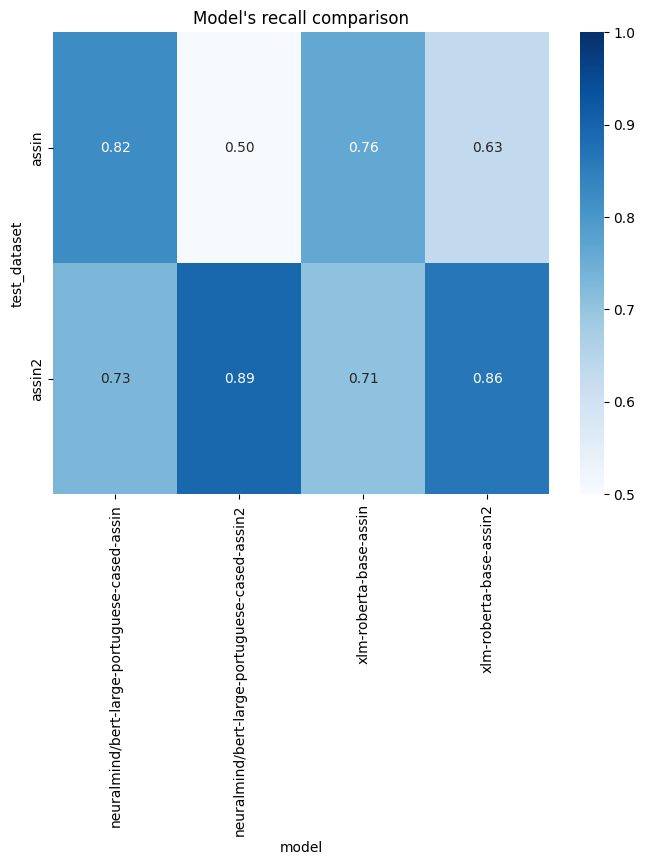

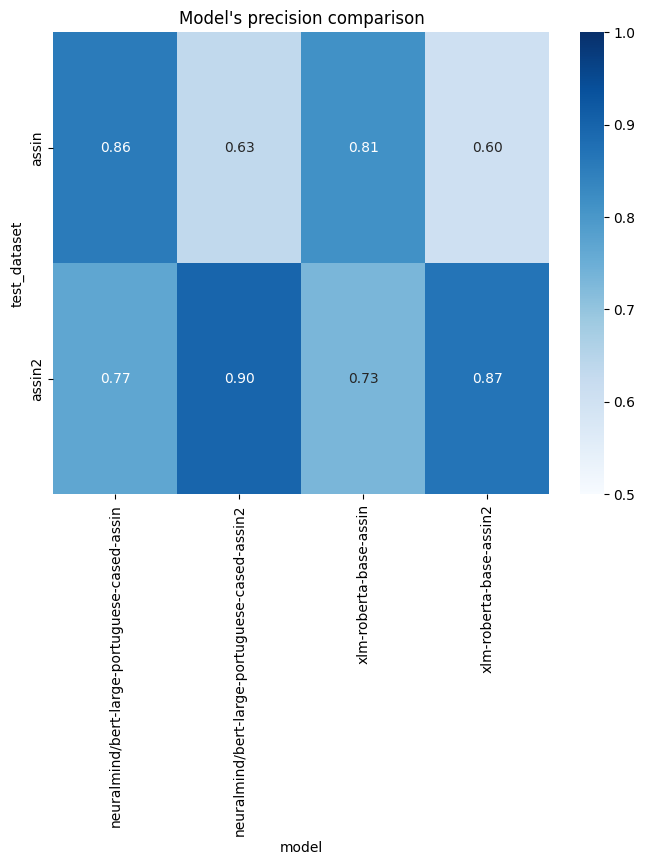

In [231]:
metrics_df["model"] = metrics_df["model_name"] + '-' + metrics_df["train_dataset"]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    plot_models_benchmark_results(metrics_df, metric)
